In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

In [2]:
catalog = fits.open('Catalogs/mactivity_movinggroups_confirmed.fits')

In [5]:
mask_ha = ((catalog[1].data['ewha'] < 20) * (~np.isnan(catalog[1].data['ewha'])) 
           * (catalog[1].data['age'] < 14*1e3) 
           * (catalog[1].data['phot_g_mean_mag'] - catalog[1].data['phot_rp_mean_mag'] > 0.5))

spt = catalog[1].data['spt'][mask_ha]
g = catalog[1].data['phot_g_mean_mag'][mask_ha]
rp = catalog[1].data['phot_rp_mean_mag'][mask_ha]
bp = catalog[1].data['phot_bp_mean_mag'][mask_ha]
g_rp = g-rp
parallax = catalog[1].data['parallax'][mask_ha]
parallax_error = catalog[1].data['parallax_error'][mask_ha]
g_abs = g - 5*(np.log10(1e3/parallax)-1)
min_halpha = np.min(catalog[1].data['ewha'][mask_ha])
ewha = catalog[1].data['ewha'][mask_ha] 
log10ewha = np.log10(ewha)
ewha_error = catalog[1].data['ewha_error'][mask_ha]
mask_nan = np.isnan(ewha_error)
ewha_error[mask_nan] = 0.2
log10ewha_error_up = np.log10(ewha + ewha_error) - log10ewha
log10ewha_error_down = log10ewha - np.log10(ewha - ewha_error)
log10ewha_error = log10ewha_error_down
#lhalbol = np.concatenate((catalog[1].data['lhalbol'][mask_ha]
#lhalbol_error = np.concatenate((catalog[1].data['lhalbol_error'][mask_ha]
age = catalog[1].data['age'][mask_ha]*1e6
log10age = np.log10(age)
group_num = catalog[1].data['group_num'][mask_ha]

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


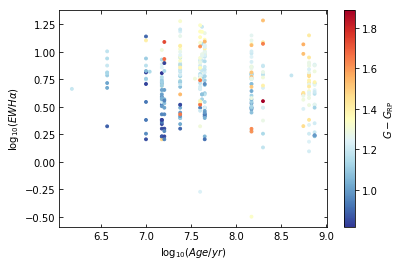

In [6]:
plt.scatter(log10age,log10ewha,c=g_rp,s=8,cmap='RdYlBu_r')
plt.tick_params('both',direction='in',top=True,right=True)
plt.tick_params('y',which='minor',direction='in',right=True)
plt.colorbar(label=r'$G-G_{\rm RP}$')
plt.xlabel(r'$\log _{10}(Age/yr)$')
plt.ylabel(r'$\log _{10}(EWH\alpha)$')
plt.savefig('/Users/rociokiman/Dropbox (Personal)/Apps/Overleaf/Age-Activity Relation for M dwarfs/ageactivity.png',
            dpi=500)